In [138]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [139]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [149]:
df_numerical_features = X_train.select_dtypes(exclude='object')
df_categorical_features = X_train.select_dtypes(include='object')

In [150]:
df_numerical_features

,condition,odometer,auction_value
7821,4.4,NaN,13800.0
4127,4.3,27368.0,21300.0
12,2.8,66470.0,10300.0
1689,3.6,25208.0,12900.0
726,3.3,41234.0,11750.0
...,...,...,...
350,NaN,49411.0,11650.0
79,4.3,36731.0,17600.0
8039,4.2,41269.0,11750.0
6936,3.5,53997.0,9550.0


In [151]:
df_categorical_features

,make,transmission,state
7821,kia,automatic,wi
4127,chrysler,automatic,ca
12,ford,automatic,fl
1689,honda,automatic,NaN
726,hyundai,automatic,NaN
...,...,...,...
350,hyundai,automatic,wi
79,NaN,NaN,NaN
8039,nissan,automatic,oh
6936,dodge,automatic,fl


In [155]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
cat_columns_selector = selector(dtype_include =object)
cat_columns = cat_columns_selector(X_train)
numeric_columns =numerical_columns_selector(X_train)
print("Categorical features are ", cat_columns)
print("Numerial features are", numeric_columns)

Categorical features are  ['make', 'transmission', 'state']
Numerial features are ['condition', 'odometer', 'auction_value']


## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [144]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer


In [156]:
numeric_pipeline = Pipeline(steps = [('imputation', SimpleImputer(missing_values = np.nan, strategy = 'median')),('scaler', StandardScaler())])
X_train_numeric_converted = numeric_pipeline.fit_transform(X_train[numeric_columns])

In [157]:
X_train_numeric_converted.shape


(7244, 3)

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays

In [158]:
categoric_pipeline = Pipeline(steps = [('imputation', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),('onehotencoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])

X_train_cat_converted = categoric_pipeline.fit_transform(X_train[cat_columns])

To ensure the pipeline doesn't break when it receives new/unexpected categories, I used handle_unknown = 'ignore' configuration for one hot encoder



In [159]:
X_train_converted.todense()

matrix([[0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [160]:
X_train_cat_converted.shape


(7244, 41)

New transformed data for categorical columns has 41 columnns, Verifying if it is right or not in  below code

In [161]:
for i in cat_columns:
    print(X_train[i].nunique())

10
2
32


Total = 44 and from each column it dropped one category using drop = 'first' parameter in one hot encoder function. so 44-3 = 41 hence it is right

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.

In [162]:
preprocessor = ColumnTransformer(transformers = [('num', numeric_pipeline,numerical_columns),('cat',categoric_pipeline, cat_columns)])
X_t= preprocessor.fit_transform(X_train)
X_t

<7244x44 sparse matrix of type '<class 'numpy.float64'>'
	with 35945 stored elements in Compressed Sparse Row format>

In [163]:
X_t.shape

(7244, 44)

transformed columns are 44 which is correct. As for categorical columns ,we saw earlier it transformed to 41 columns using one hot encoder and we have 3 numeric columns. Hence it is verifed that it is correct

In [171]:
np.isnan(X_t.todense()).sum()

0

No missing values in the transformed data

## Question 5: Add a linear regression model to the pipeline.

In [184]:
pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', LinearRegression())])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

score = pipeline.score(X_test,y_test)
print(score)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)



0.883827413318118
0.883827413318118


In [183]:
training_score = pipeline.score(X_train,y_train)
training_score

0.8688622550878699

training score is not much higher than testing score. hence there is no overfitting much

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?

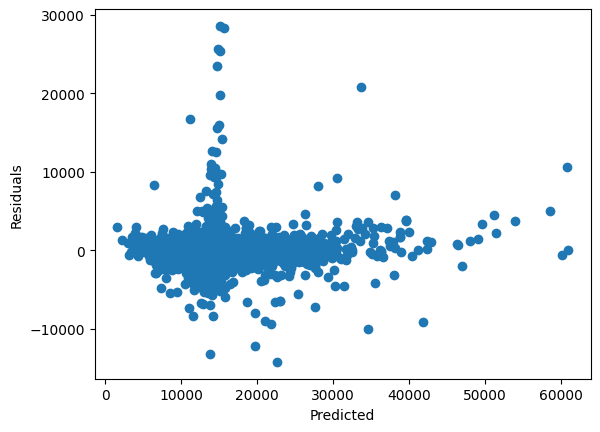

In [177]:
import matplotlib.pyplot as plt

residuals = y_test- y_pred
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.scatter(y_pred, residuals)
plt.show()


In the plot, the residuals appear to be randomly scattered around zero and we see no patterns so which indicates that model is capturing all the information to predict selling price.If errors are not randomly spread, we can say that linear model is not appropriate for this data but which is not the case here it seems.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the 
R squared?

In [186]:
pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha = 100))])

In [187]:

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

score = pipeline.score(X_test,y_test)
score

0.88242952622921

There is no much change in Rsquared value and difference is relatively small. It performed similar to basic what normal regression did.